# THIS NOTEBOOK IS DEDICATED TO THE ANALYSIS OF 

# *CoT task*


In [141]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
import types
import inspect
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from pylab import *
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA

ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run Lesion_Size.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
os.chdir(CWD)

# logging.getLogger().setLevel(logging.WARNING)
defaultParam={
            "treadmillRange":[0,65],
            "binSize":0.25,
            "trialOffset":20., #max end of trial, in seconds (position will be cutted)
            "sigmaSmoothPosition":0.1,  #smooth the position
            #"sigmaSmoothPosition":0.33 for pavel dataType
            "sigmaSmoothSpeed":0.3, #smooth the speed
            "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                          #min to correct start, max to correct jumps
            "pawFrequencyRange":[2.,10.],
            "startAnalysisParams":[10,0.2,0.5],
            "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
            "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked


            #parameter to detect end of trial (first position minima)
            "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
            "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
            "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }

print('Done')

Done


# DEFINITIONS

In [109]:
profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0','10'],
         'Speed':'0',
         'Tag':['ImmobileTreadmill-EXP','CoT']
         }

animalList=['Rat369','Rat371']

In [143]:
sessionList=batch_get_session_list(root,animalList,profile)['Sessions']
sessionList

['Rat369_2019_10_03_15_42',
 'Rat369_2019_10_04_13_44',
 'Rat369_2019_10_07_16_16',
 'Rat369_2019_10_08_16_03',
 'Rat369_2019_10_09_14_51',
 'Rat369_2019_10_10_15_44',
 'Rat371_2019_10_09_11_04',
 'Rat371_2019_10_09_15_51',
 'Rat371_2019_10_10_11_03']

In [139]:
data.position[18].max()

69.22471876449592

In [144]:
speed=[]
for session in sessionList:
    data=Data(root,session[:6],session,saveAsPickle=False,param=defaultParam)
    spd=forwardRunningSpeed(data).compute().values()
    speed.extend(list(spd))
    print(session,np.nanmedian(list(spd)))
print(np.nanmedian(speed),np.nanstd(speed))    

Rat369_2019_10_03_15_42 61.94374521234203
Rat369_2019_10_04_13_44 55.632643725415186
Rat369_2019_10_07_16_16 66.69955650832269
Rat369_2019_10_08_16_03 65.90278786283841
Rat369_2019_10_09_14_51 65.49804953606062
Rat369_2019_10_10_15_44 69.1158786727774
Rat371_2019_10_09_11_04 65.36133964412458
Rat371_2019_10_09_15_51 65.429059214658
Rat371_2019_10_10_11_03 68.9621370034419
65.20568404473646 11.435555946275606


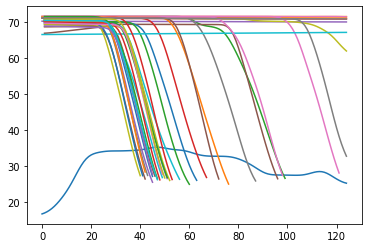

In [126]:
for pos in get_positions_array_end_StereotypedTrials(data):
    plt.plot(pos)
plt.show()

In [83]:
a=get_positions_array_end_StereotypedTrials(data)

In [84]:
speed=forwardRunningSpeed(data).compute()

In [85]:
np.nanmedian(list(speed.values())),np.nanstd(list(speed.values()))

(66.69955650832269, 15.471872450996955)